In [ ]:
!pip install -q -U pytorch_lightning wandb

In [ ]:
# Утилиты стандартной библиотеки
from functools import lru_cache
import os

# Библиотеки для анализа данных
import numpy as np

# Библиотеки для обработки изображений
from PIL import Image
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

# Библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Библиотеки для обучения
import pytorch_lightning as pl
import albumentations as A
import wandb
from pytorch_lightning.loggers import WandbLogger
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

### Данные

Поработаем с подмножеством датасета [Carvana](https://www.kaggle.com/c/carvana-image-masking-challenge) с Kaggle. Carvana &mdash; это онлайн магазин подержаннных aвтомобилей. Компания организовала соревнование для того, чтобы получить модель, с помощью которой получилось бы автоматически сегментировать авто на фотографии. Затем, используя маску для автомобиля, его можно было использовать для получения более интересных фотографий с автомобилем.


Мы не будем использовать датасет целиком, так как он очень большой, а для наших целей хватит небольшой его части.

Скачаем архив с даными [здесь](https://drive.google.com/file/d/1UbXOTP6GIp1pp-LwwpfX1p8m6iaWXzM1/view?usp=drive_link).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data_path = './carvana'
!unzip "/content/drive/MyDrive/DS/carvana.zip" -d $data_path

Данные уже разделены на трейн и тест. В папках `train` и `train_masks` лежат изображения автомобилей и их маски соответственно. Аналогично для папок `test` и `test_masks`.

In [ ]:
data_path = './carvana'
!ls $data_path

test  test_masks  train  train_masks


Изображения и маски имеют одинаковое начало названия. Название файла маски отличается тем, что есть окончание `_mask`, а также сам файл имеет другой формат &mdash; gif вместо jpg. Так можно получить изображение и его маску из трейна.


In [ ]:
img_name = "0cdf5b5d0ce1_01.jpg"
splitted = img_name.split('.')
mask_name = splitted[0] + "_mask" + ".gif"

img_path = os.path.join(data_path, "train", img_name)
mask_path = os.path.join(data_path, "train_masks", mask_name)

Визуализируем изображение и маску.

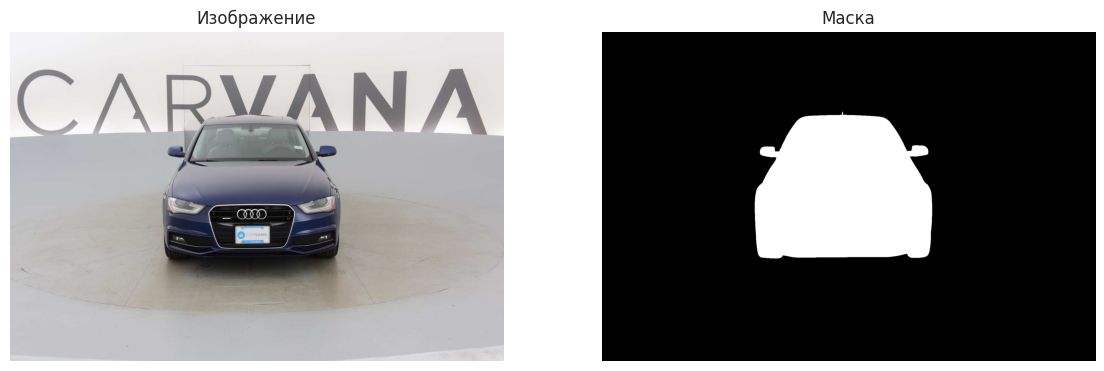

In [ ]:
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.title("Изображение")
plt.imshow(Image.open(img_path))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Маска")
plt.imshow(Image.open(mask_path))
plt.axis("off");

Исходные изображения довольно большие. Предлагаем работать с изображениями меньшего размера, а именно (160, 240) для уменьшения вычислительных затрат.

In [ ]:
Image.open(img_path).size

(1918, 1280)

### Задача 1. Простая сегментация
Построим свою собственную модель сегментации и проведем анализ ее работы.

#### 1. Обучение сегментации

Построим модель типа U-Net.

Здесь реализована оригинальная архитектура U-Net.

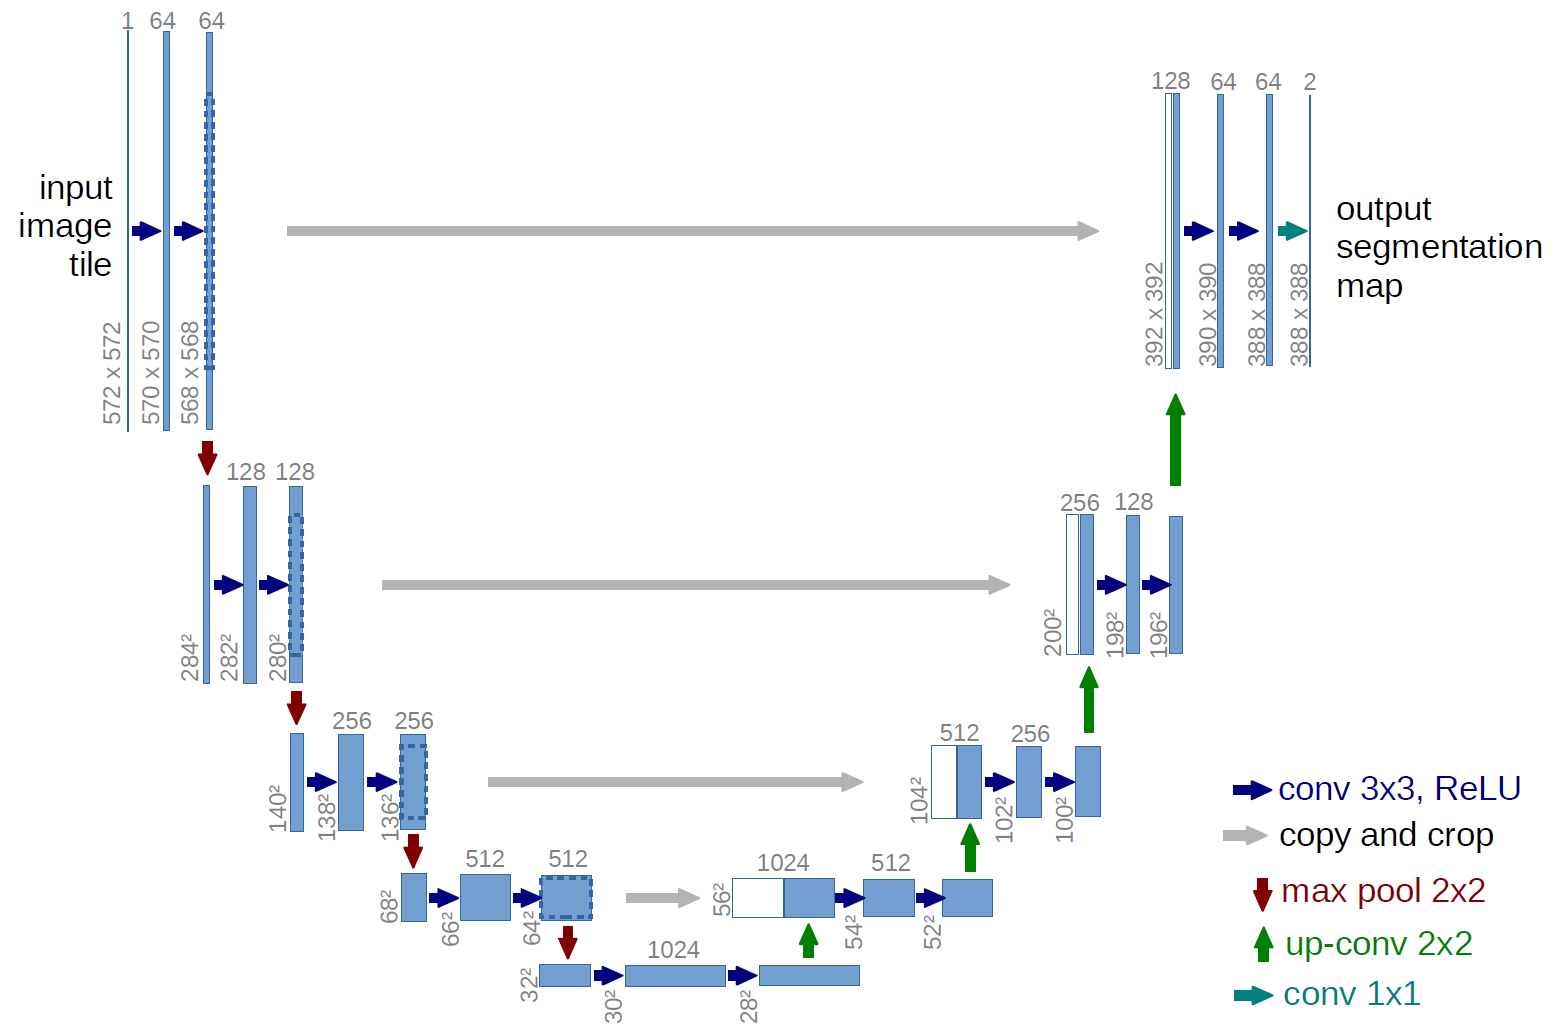

In [ ]:
class ConvBnRelu(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel=3, stride=1, padding=1):
        '''Последовательность свертки, BN, ReLU'''
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels,
                    kernel_size=kernel, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(num_features=out_channels)
        self.relu = nn.ReLU(inplace=True)


class Stacked2ConvsBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        '''2 последовательные свертки'''
        super().__init__()
        self.first = ConvBnRelu(in_channels, out_channels)
        self.second = ConvBnRelu(out_channels, out_channels)


class DownSamplingBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        '''Блок для downsampling с in_channels до out_channels в левой части'''
        super().__init__()
        self.mp = nn.MaxPool2d(2, 2)
        self.two_convs = Stacked2ConvsBlock(in_channels, out_channels)


class UpSamplingBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        '''Блок для upsampling с in_channels до out_channels в правой части'''
        super().__init__()

        # Повышаем размерность
        self.upsample = nn.ConvTranspose2d(in_channels, in_channels, kernel_size=2, stride=2)
        self.convolve = Stacked2ConvsBlock(2 * in_channels, out_channels)

    def forward(self, left_net, right_net):
        '''Стакает с симметричным слоем из левой части U-Net'''
        right_net = self.upsample(right_net)
        net = torch.cat([left_net, right_net], dim=1)
        net = self.convolve(net)
        return net


class Unet(nn.Module):
    def __init__(self, layer_widths=[64, 128, 256, 512, 1024]):
        '''Реализация U-Net
        * layer_width -- список ширин скрытых слоев'''
        super().__init__()
        self.num_tiers = len(layer_widths)
        self.init_conv = Stacked2ConvsBlock(3, layer_widths[0])

        self.downsample = nn.ModuleList()
        for i in range(self.num_tiers - 1):
            self.downsample.append(DownSamplingBlock(layer_widths[i], layer_widths[i+1]))

        # В середине есть блок без пары с 1024 каналами
        # с ним конкатенировать некого, потому просто свернём его
        self.upconv = Stacked2ConvsBlock(layer_widths[-1], layer_widths[-2])

        # Подъём. Аналогично.
        self.upsample = nn.ModuleList()
        for i in range(self.num_tiers - 2, 0, -1):
            self.upsample.append(UpSamplingBlock(layer_widths[i], layer_widths[i-1]))

        # Чтобы учесть входной слой после самой первой свёртки и согласовать размерности
        self.upsample.append(UpSamplingBlock(layer_widths[0], layer_widths[0]))

        # Предсказание
        self.agg_conv = nn.Conv2d(layer_widths[0], 1, kernel_size=1)

    def forward(self, x):
        '''Описывает forward pass в U-Net'''
        lhs_outputs = []
        lhs_outputs.append(self.init_conv(x)) # 3 --> 64

        for i in range(self.num_tiers - 1):
            # 64 --> 128 --> 256 --> 512
            lhs_outputs.append(self.downsample[i](lhs_outputs[-1]))

        output = self.upconv(lhs_outputs[-1]) # 1024 --> 512

        for i in range(self.num_tiers - 1):
            # 512 --> 256 --> 128 --> 64 --> 64
            output = self.upsample[i](lhs_outputs[-2-i], output)

        output = self.agg_conv(output) # 64 --> 1

        return output

Обучим модель на тренировочной части данных. В качестве метрики качества будем использовать IoU. Визуализируем изменение ошибки (loss) и метрики (IoU) на тренировочной и тестовой части данных.

Датасет для работы с данными.

In [ ]:
class CarvanaDataset(Dataset):
    def __init__(self, images_filenames, images_directory, masks_directory,  transform=None):
        '''Задаем аугментации и пути к картинкам и маскам'''
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.masks_directory = masks_directory
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    @lru_cache(maxsize=100)
    def _get_image_mask(self, image_filename):
        '''Получим картинку и маску для файла image_filename'''
        # Считываем изображение
        image = np.array(Image.open(os.path.join(self.images_directory, image_filename)))

        # Считываем маску
        splitted = image_filename.split('.')
        mask_filename = splitted[0] + "_mask" + ".gif"
        mask = np.array(Image.open(os.path.join(self.masks_directory, mask_filename)))
        return image, mask

    def __getitem__(self, idx):
        '''Получим картинку и маску индекса idx'''
        image_filename = self.images_filenames[idx]
        image, mask = self._get_image_mask(image_filename)

        # Применяем трансформацию (аугментацию)
        try:
            transformed = self.transform(image=image, mask=mask)
        except:
            print(image_filename)
            raise ValueError
        image = transformed["image"]
        mask = transformed["mask"]

        return np.moveaxis(image.astype(np.float32), 2, 0), mask.astype(np.float32)[None]

Определим пути до изображений и масок для тренировочной и тестовых частей данных.

In [ ]:
train_directory = os.path.join(data_path, "train")
train_masks_directory = os.path.join(data_path, "train_masks")

test_directory = os.path.join(data_path, "test")
test_masks_directory = os.path.join(data_path, "test_masks")

train_filenames = list(sorted(os.listdir(train_directory)))
test_filenames = list(sorted(os.listdir(test_directory)))

Зададим датасеты, где все изображения приведены к одному размеру.

In [ ]:
transform = A.Resize(160, 240)

train_dataset = CarvanaDataset(train_filenames, train_directory, train_masks_directory, transform=transform)
test_dataset = CarvanaDataset(test_filenames, test_directory, test_masks_directory, transform=transform)

Проверим, что датасет корректен.

In [ ]:
image, mask = train_dataset[0]
image.shape, mask.shape

((3, 160, 240), (1, 160, 240))

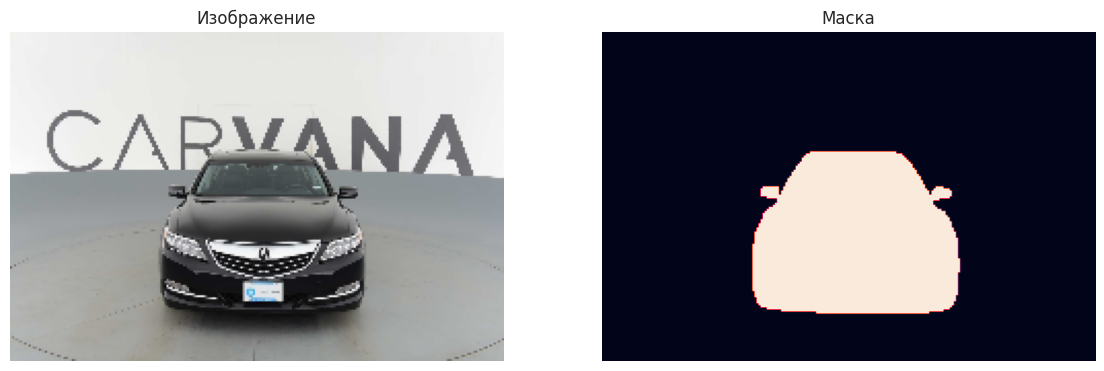

In [ ]:
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.title("Изображение")
plt.imshow(np.moveaxis(image, 0, 2).astype(int))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Маска")
plt.imshow(mask[0])
plt.axis("off");

In [ ]:
batch_size = 16
num_workers = 2
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                         num_workers=num_workers)

Реализуем функционал для обучения моделей.

In [ ]:
def IoU(output, target, threshold=0.5, epsilon=1e-8, average='mean'):
    '''Считает IOU по output, target
    * threshold : параметр IoU
    * epsilon : добавка для числ. стабильности
    * average : mean -> вернет среднее, None -> вернет BS значений'''
    TP = ((output >= threshold) & (target >= threshold)).sum(axis=(2, 3))
    FP = ((output >= threshold) & (target < threshold)).sum(axis=(2, 3))
    FN = ((output < threshold) & (target >= threshold)).sum(axis=(2, 3))
    iou = TP / (TP + FP + FN + epsilon)
    if average == 'mean':
        return iou.mean()
    elif average is None:
        return iou.flatten()
    else:
        raise NotImplementedError

Реализуем pytorch lightning module:

In [ ]:
class UNetModel(pl.LightningModule):
    def __init__(self, lr=2e-3, layer_widths=[64, 128, 256, 512, 1024]):
        '''Инициализирует модуль
        * layer_widths -- список размерностей скрытых слоев в U-Net'''
        super().__init__()
        self.lr = lr
        self.criterion = nn.BCEWithLogitsLoss()
        self.save_hyperparameters()
        self.model = Unet(layer_widths=layer_widths)
        self.predictions = []
        self.metric = IoU

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

    def forward(self, x):
        return self.model(x)

    def __step(self, batch, name):
        ''' Описывает 1 шаг обучения на batch
        * name -- либо train, либо val'''
        images, target = batch
        output = self.forward(images)
        loss = self.criterion(output, target)
        iou = self.metric(output, target)
        self.log(name+'_loss', loss)
        self.log(name+'_iou', iou, on_step=False, on_epoch=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self.__step(batch, 'train')

    def validation_step(self, batch, batch_idx):
        return self.__step(batch, 'val')

Объявим trainer и обучим:

In [ ]:
model = UNetModel()
checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor='val_iou', mode='max')
wandb_logger = WandbLogger(project='Segmentation', log_model='all')
trainer = pl.Trainer(logger=wandb_logger,
                     accelerator='gpu',
                     max_epochs=10,
                     devices=1,
                     callbacks=[checkpoint_callback])

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, train_loader, test_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params
------------------------------------------------
0 | criterion | BCEWithLogitsLoss | 0     
1 | model     | Unet              | 31.3 M
------------------------------------------------
31.3 M    Trainable params
0         Non-trainable params
31.3 M    Total params
125.241   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Завершим запуск и сохраним модель.

In [ ]:
wandb.finish()
!cp /content/Segmentation/qukycgp0/checkpoints/epoch=9-step=5730.ckpt /content/drive/MyDrive/DS

epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_iou,▁▆▆▇▇█▇███
train_loss,█▄▂▂▂▂▂▁▂▂▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_iou,▁▇▁▆▆▇▇▇▇█
val_loss,█▃▇▂▃▂▂▂▂▁
epoch,9
train_iou,0.98367
train_loss,0.00782
trainer/global_step,5729
val_iou,0.98387


Графики обучения.

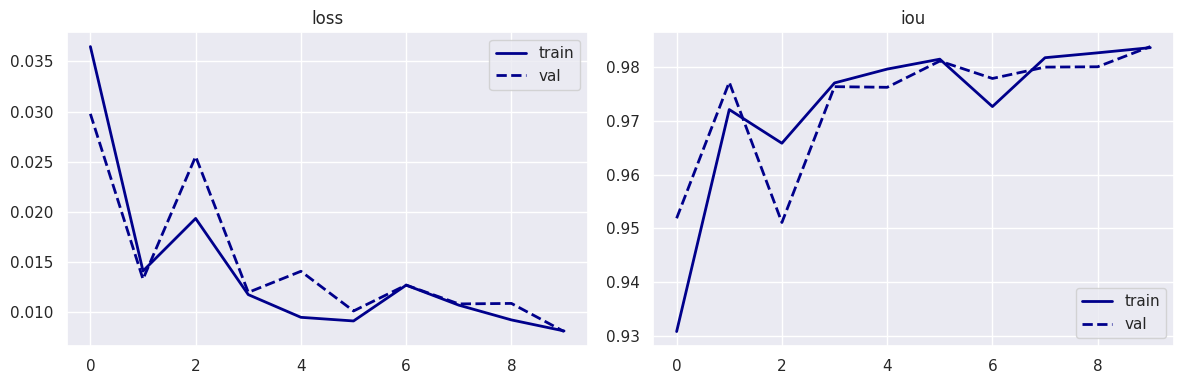

In [ ]:
runs = wandb.Api().runs("Segmentation")
subplot_names = np.array(['loss', 'iou'])

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
lw = 2
for i, run in enumerate(runs):
    df = run.history().groupby('epoch').mean(numeric_only=True)
    for m in range(2):
        axs[m].set_title(subplot_names[m])
        axs[m].plot(df['train_'+subplot_names[m]], lw=lw, c='darkblue', label='train')
        axs[m].plot(df['val_'+subplot_names[m]], lw=lw, ls='--', c='darkblue', label='val')
        axs[m].legend()
plt.tight_layout()

Как быстро обучается модель? Как вы думаете с чем это связано?

**Ответ:** Модель быстро достигает хорошего качества, видимо, датасет достаточно простой для обучения.

#### 2. Анализ модели
Выберем 10 изображений из тестовой части данных и посчитайте качество модели на них. Теперь поменяем фон для изображений.

Выберем 10 изображений и соберем их маски.

In [ ]:
np.random.seed(42)
idx = np.random.choice(np.arange(len(test_dataset)), 10, replace=False)
images, imgs_new_bg, masks = [], [], []
for i in idx:
    image, mask = test_dataset[i]
    images.append(image)
    masks.append(mask)
    # изобр. с новым фоном
    img_new_bg = image.copy()
    img_new_bg[:, mask[0] < 0.5] = np.array((50, 50, 20))[:, None]
    imgs_new_bg.append(img_new_bg)

Соберем предсказания для 2 вариантов картинок.

In [ ]:
image_batch = torch.from_numpy(np.stack(images))
img_new_bg_batch = torch.from_numpy(np.stack(imgs_new_bg))
mask_batch = torch.from_numpy(np.stack(masks))

model.eval()
with torch.no_grad():
    pred_batch = torch.sigmoid(model(image_batch))
    pred_new_batch = torch.sigmoid(model(img_new_bg_batch))

iou = IoU(pred_batch, mask_batch, average=None)
iou_new = IoU(pred_new_batch, mask_batch, average=None)

Наконец, визуализируем предсказания и истину.

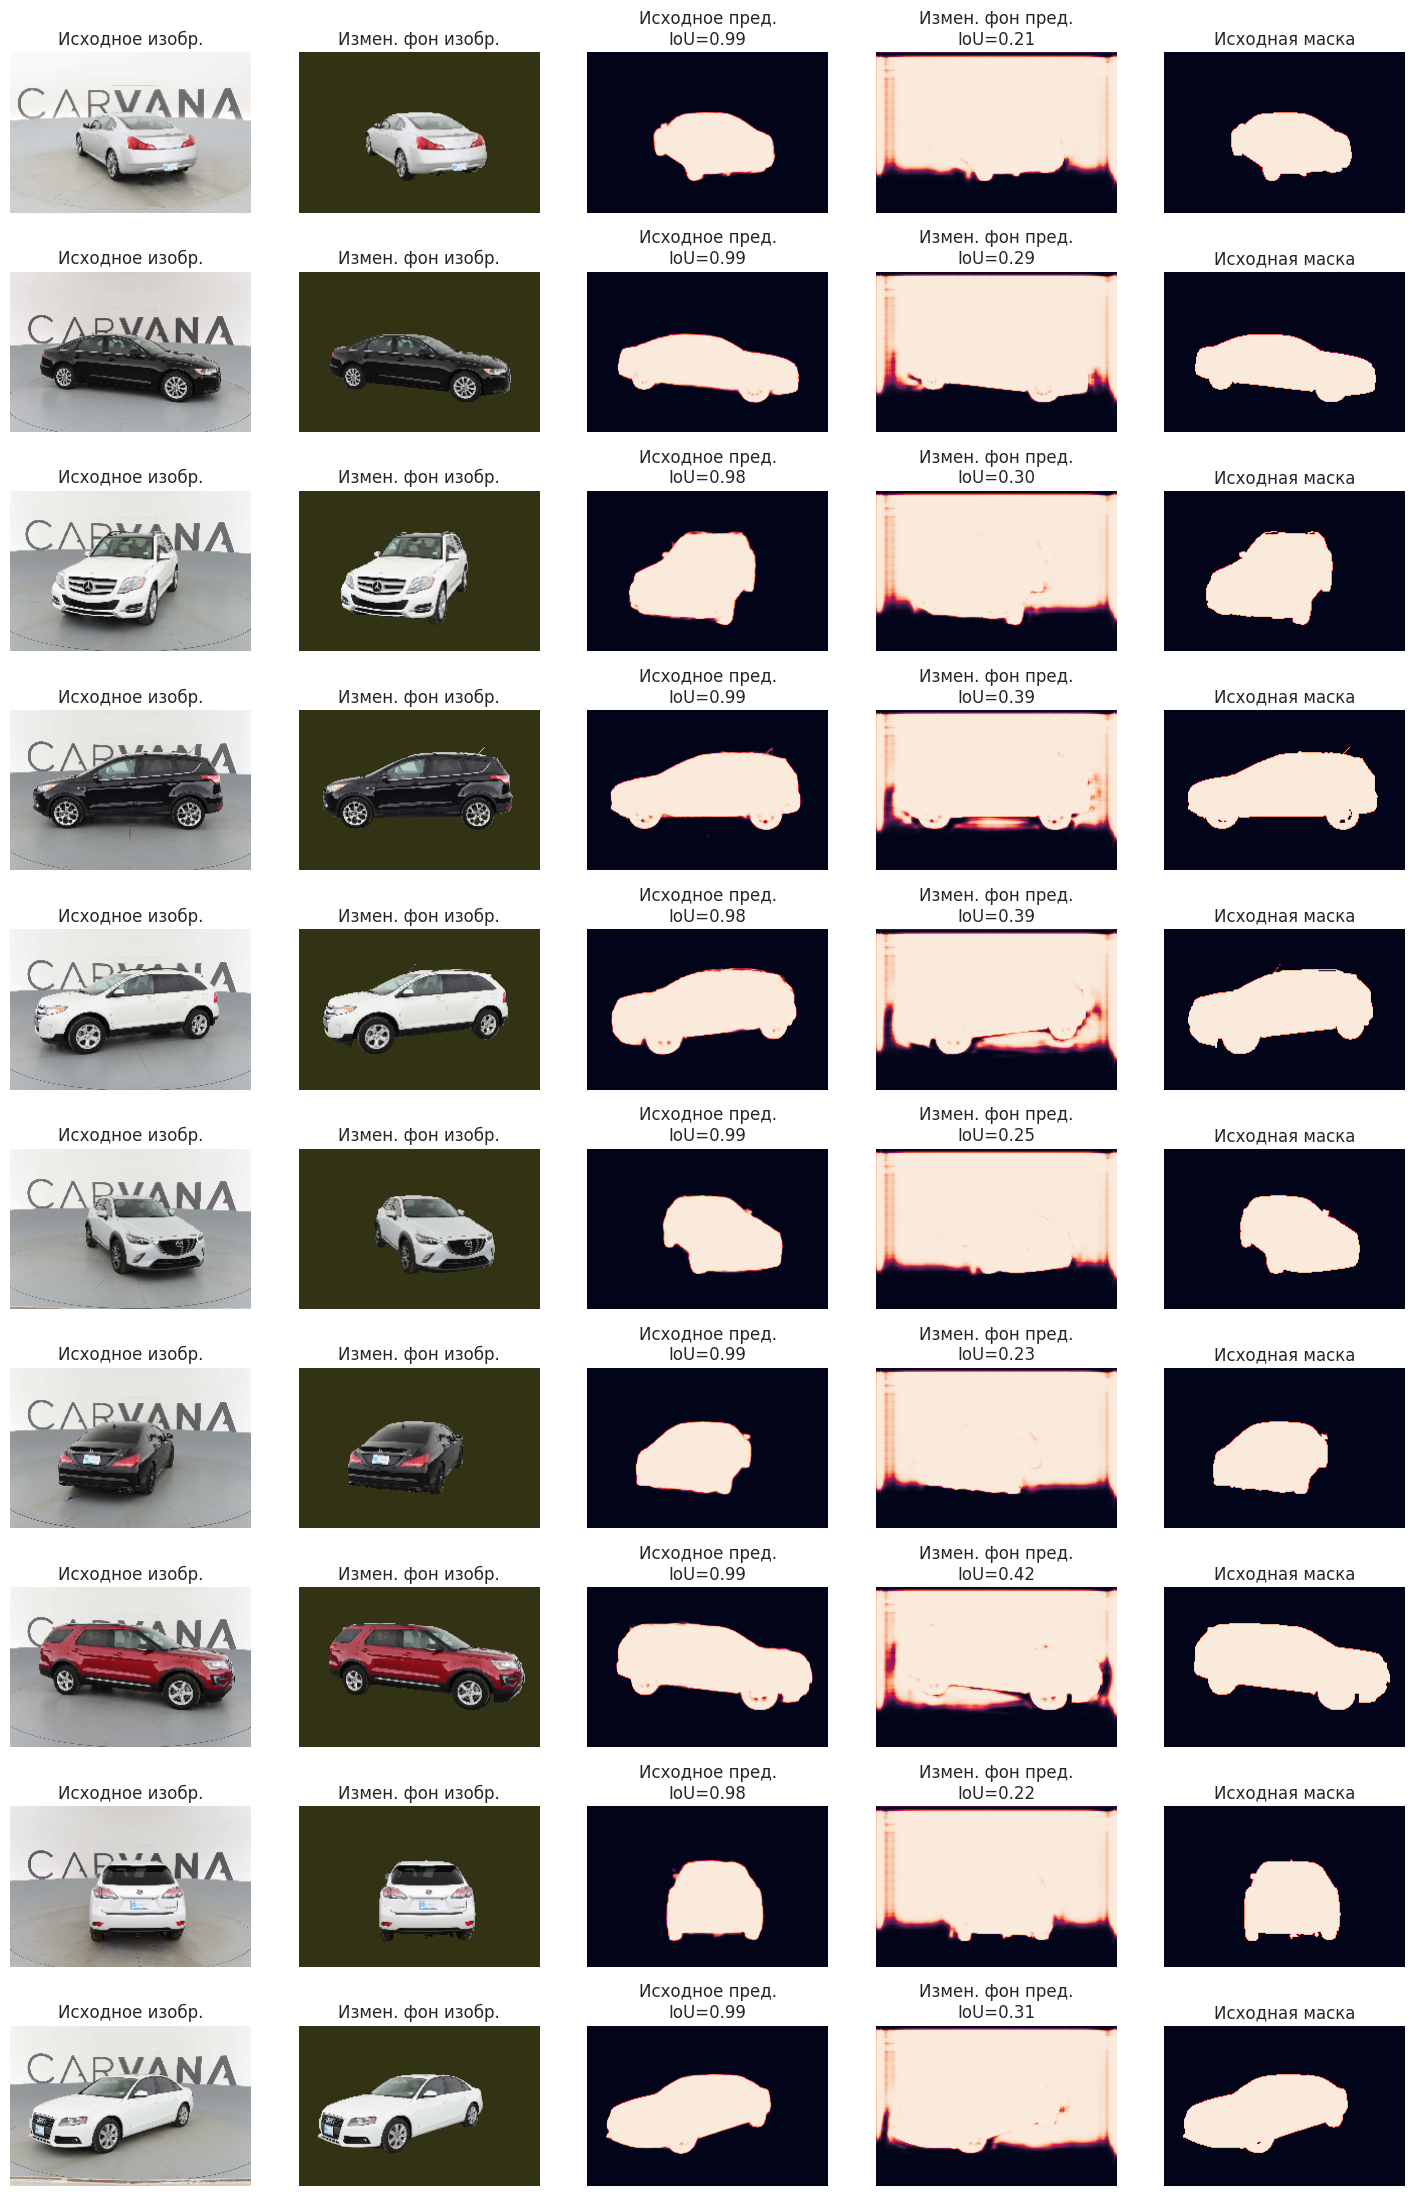

In [ ]:
# Визуализируем
fig, axs = plt.subplots(10, 5, figsize=(18, 28))
for i in range(10):
    image, img_new_bg, mask = images[i], imgs_new_bg[i], masks[i][0]
    pred, pred_new = pred_batch[i][0], pred_new_batch[i][0]
    axs[i][0].imshow(np.moveaxis(image, 0, 2).astype(int))
    axs[i][0].axis("off")
    axs[i][0].set_title('Исходное изобр.')
    axs[i][1].imshow(np.moveaxis(img_new_bg, 0, 2).astype(int))
    axs[i][1].axis("off");
    axs[i][1].set_title('Измен. фон изобр.')
    axs[i][2].imshow(pred)
    axs[i][2].axis("off");
    axs[i][2].set_title(f'Исходное пред.\nIoU={iou[i].item():.2f}')
    axs[i][3].imshow(pred_new)
    axs[i][3].axis("off");
    axs[i][3].set_title(f'Измен. фон пред.\nIoU={iou_new[i].item():.2f}')
    axs[i][4].imshow(mask)
    axs[i][4].axis("off");
    axs[i][4].set_title('Исходная маска')

Загрузим несколько фотографий машин не из датасета и девушку в красном платье на сером фоне.

In [ ]:
# Предобработка
images_path = '/content/drive/MyDrive/DS/cars'
images = []
for image_name in sorted(os.listdir(images_path)):
    image = Image.open(os.path.join(images_path, image_name))
    image = transform(image=np.array(image))['image']
    image = np.moveaxis(image, 2, 0).astype(np.float32)
    images.append(image)

image_batch = torch.from_numpy(np.stack(images))

# Предсказания
model.eval()
with torch.no_grad():
    pred_batch = torch.sigmoid(model(image_batch))

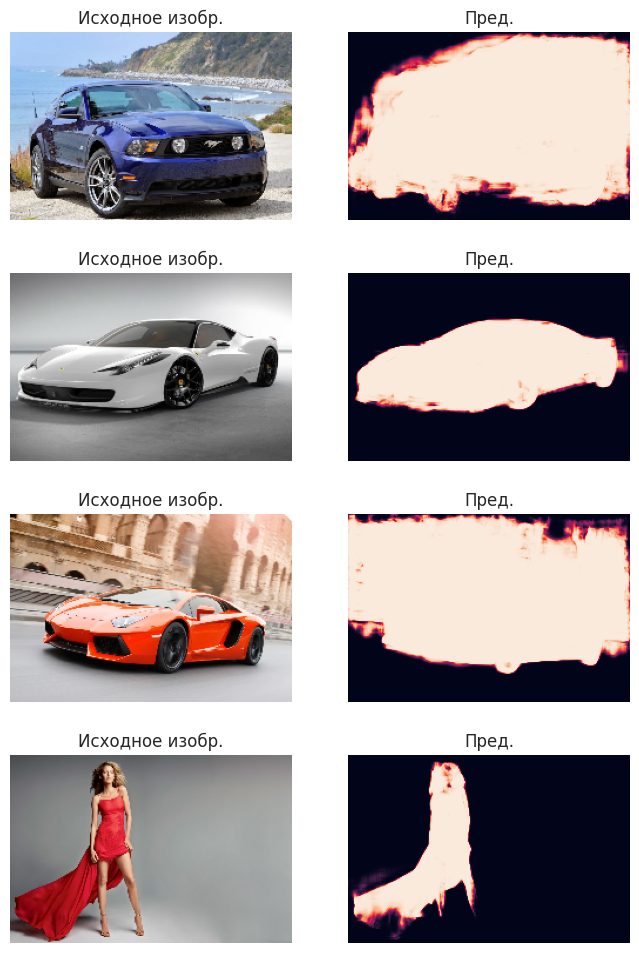

In [ ]:
# Визуализируем
fig, axs = plt.subplots(4, 2, figsize=(8, 12))
for i in range(4):
    image, pred = images[i], pred_batch[i][0]
    axs[i][0].imshow(np.moveaxis(image, 0, 2).astype(int))
    axs[i][0].axis("off")
    axs[i][0].set_title('Исходное изобр.')
    axs[i][1].imshow(pred)
    axs[i][1].axis("off");
    axs[i][1].set_title('Пред.')

Модель научилась определять контрастные объекты на достаточно светлом, монотонном и близкому к серому фоне. Конкректно машины модель не различает.

#### 3. Тестирование на датасете CityScapes
Проверим обобщающую способность модели на небольшом подмножестве датасета [CityScapes](https://www.cityscapes-dataset.com/). Этот датасет состоит из кадров съемки автомобиля, движущегося по улицам преимущественно Германии. Мы будем использовать подмножество из 300 изображений для тестирования модели.

Скачаем [архив](https://disk.yandex.ru/d/J8gPv_bEiK-_QQ) с данными с диска. В папках `images` и `masks` лежат изображения и маски автомобилей соответственно.

Подготовим класс датасета.

In [ ]:
class CityScapesDataset(Dataset):
    def __init__(self, images_filenames, images_directory, masks_directory,  transform=None):
        '''Задаем аугментации и пути к картинкам и маскам'''
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.masks_directory = masks_directory
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    @lru_cache(maxsize=100)
    def _get_image_mask(self, image_filename):
        '''Получим картинку и маску для файла image_filename'''
        # Считываем изображение
        image = np.array(Image.open(os.path.join(self.images_directory, image_filename)))

        # Считываем маску
        splitted = image_filename.split('.')
        mask_filename = splitted[0] + "_mask" + ".png"

        mask = np.array(Image.open(os.path.join(self.masks_directory, mask_filename))).clip(0, 1)

        return image, mask

    def __getitem__(self, idx):
        '''Получим картинку и маску индекса idx'''
        image_filename = self.images_filenames[idx]
        image, mask = self._get_image_mask(image_filename)

        # Применяем трансформацию (аугментацию), если это необходимо
        if self.transform is not None:
            try:
                transformed = self.transform(image=image, mask=mask)
            except:
                print(image_filename)
                raise ValueError
            image = transformed["image"]
            mask = transformed["mask"]

        return np.moveaxis(image.astype(np.float32), 2, 0), mask.astype(np.float32)[None]

Запишем пути до изображений и масок.

In [ ]:
!unzip "/content/drive/MyDrive/DS/cityscapes.zip" -d '/content'
CS_data_path = '/content/cityscapes'
CS_images_directory = os.path.join(CS_data_path, "images")
CS_masks_directory = os.path.join(CS_data_path, "masks")
CS_filenames = list(sorted(os.listdir(CS_images_directory)))

Определим датасет.

In [ ]:
CS_dataset = CityScapesDataset(CS_filenames, CS_images_directory, CS_masks_directory, transform=transform)

Проверим его корректность.

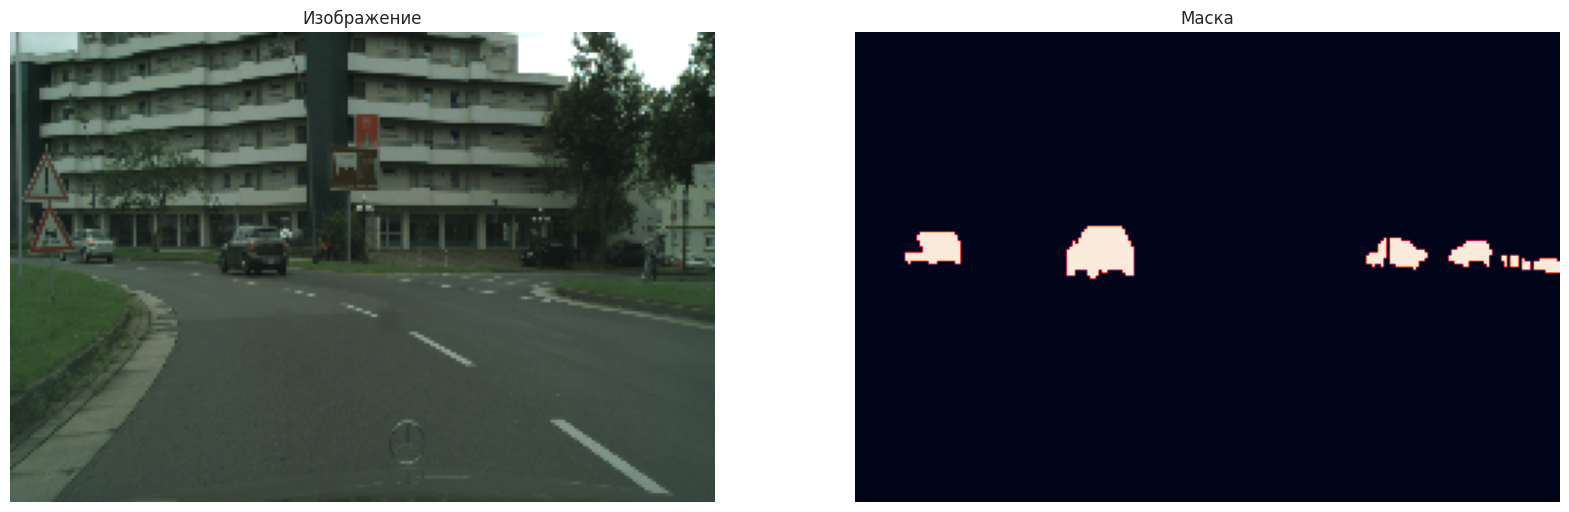

In [ ]:
image, mask = CS_dataset[0]

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.title("Изображение")
plt.imshow(np.moveaxis(image, 0, 2).astype(int))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Маска")
plt.imshow(mask[0])
plt.axis("off");

Посчитайте качество сегментации модели на датасете CityScapes. Поясните результат.

In [ ]:
CS_loader = DataLoader(
    CS_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
)

In [ ]:
trainer.validate(model=model, dataloaders=CS_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_iou          │    0.0849781334400177     │
│         val_loss          │    4.0543622970581055     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 4.0543622970581055, 'val_iou': 0.0849781334400177}]

**Вывод:** Данный датасет разительно отличается от датасета Carvana. Машины здесь сняты в городской среде, они часто имеют небольшой размер и их может быть довольно много на одной фотографии. Тем более модель, как мы выяснили раньше, вовсе не умеет определять машины. Поэтому качество получилось настолько маленьким.